In [2]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 27.6 MB/s eta 0:00:00


In [4]:
!pip install torch torchvision captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.3 MB/s eta 0:00:00


In [5]:
!pip install matplotlib==3.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import shap
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import DeepFool
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.attacks.evasion import NewtonFool
import art.attacks.evasion
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist


# Build Model and Train it


In [3]:
# Step 0: Define the neural network model, return logits instead of activation in forward method
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

# Step 0: Define the neural network model, return logits instead of activation in forward method
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
#         x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
#         x = x.view(-1, 320)
#         x = nn.functional.relu(self.fc1(x))
#         x = self.fc2(x)
#         return nn.functional.log_softmax(x, dim=1)


In [4]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
y_train = np.argmax(y_train, axis=1)
y_test= np.argmax(y_test, axis=1)

In [32]:


# Step 2: Create PyTorch DataLoader objects

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Step 3: Define the loss function and optimizer

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the model

num_epochs = 10

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Compute statistics
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)
    
    train_loss /= len(train_loader.dataset)
    train_acc = train_acc.float() / len(train_loader.dataset)
    
    print('Epoch: {}, Training Loss: {:.4f}, Training Accuracy: {:.4f}'.format(epoch+1, train_loss, train_acc))
    
    # Evaluate on the test set
    test_loss = 0.0
    test_acc = 0.0
    
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)
    
    test_loss /= len(test_loader.dataset)
    test_acc = test_acc.float() / len(test_loader.dataset)
    
    print('Epoch: {}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(epoch+1, test_loss, test_acc))


Epoch: 1, Training Loss: 1.6705, Training Accuracy: 0.8031
Epoch: 1, Test Loss: 1.5601, Test Accuracy: 0.9062
Epoch: 2, Training Loss: 1.5515, Training Accuracy: 0.9137
Epoch: 2, Test Loss: 1.5381, Test Accuracy: 0.9259
Epoch: 3, Training Loss: 1.5328, Training Accuracy: 0.9312
Epoch: 3, Test Loss: 1.5234, Test Accuracy: 0.9407
Epoch: 4, Training Loss: 1.5235, Training Accuracy: 0.9398
Epoch: 4, Test Loss: 1.5130, Test Accuracy: 0.9500
Epoch: 5, Training Loss: 1.5188, Training Accuracy: 0.9433
Epoch: 5, Test Loss: 1.5112, Test Accuracy: 0.9505
Epoch: 6, Training Loss: 1.5132, Training Accuracy: 0.9493
Epoch: 6, Test Loss: 1.5090, Test Accuracy: 0.9539
Epoch: 7, Training Loss: 1.5113, Training Accuracy: 0.9509
Epoch: 7, Test Loss: 1.5089, Test Accuracy: 0.9535
Epoch: 8, Training Loss: 1.5092, Training Accuracy: 0.9528
Epoch: 8, Test Loss: 1.4997, Test Accuracy: 0.9630
Epoch: 9, Training Loss: 1.5062, Training Accuracy: 0.9557
Epoch: 9, Test Loss: 1.4964, Test Accuracy: 0.9660
Epoch: 10,

In [ ]:
# Step 2: Create and load the model
state_dict = torch.load("/content/mnist_model_adv.pth")
model = Net()
model.load_state_dict(state_dict)


# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)


In [33]:
# model = Net()
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

In [10]:
# # Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [11]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))


Accuracy on benign test examples: 97.99%


In [13]:
# Save the trained model
torch.save(model.state_dict(), '/content/mnist_model_adv4.pth')

# Generate different types of ADV samples

In [14]:
#FGD
attack_FGD = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv_FGD = attack_FGD.generate(x=x_test)


In [26]:
#PGD
attack_PGD= ProjectedGradientDescentPyTorch(estimator=classifier)
x_test_adv_PGD = attack_PGD.generate(x=x_test)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [34]:
#Deepfool
attack_DF=DeepFool(classifier=classifier)
x_test_adv_DF= attack_DF.generate(x=x_test)

DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

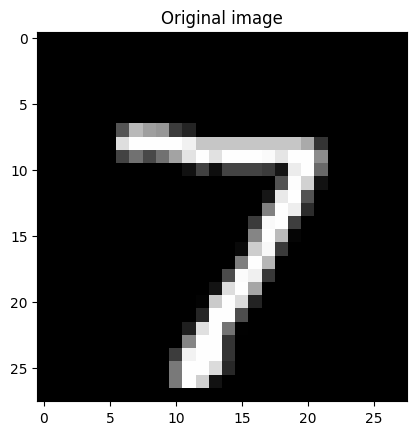

In [15]:
#visualize the image before attack
plt.imshow(np.transpose(x_test[0], (1, 2, 0)),cmap='gray')
plt.title("Original image")
plt.show()


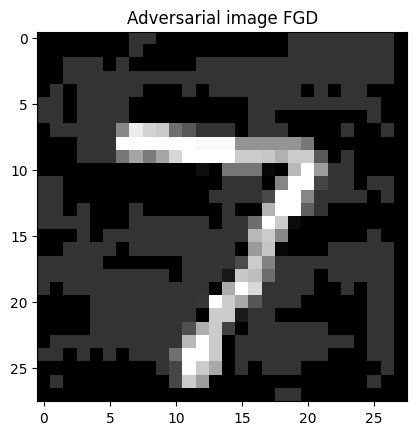

In [16]:
# Visualize the  image  after generating FGD attack
plt.imshow(np.transpose(x_test_adv_FGD[0], (1, 2, 0)),cmap='gray')
plt.title("Adversarial image FGD")
plt.show()


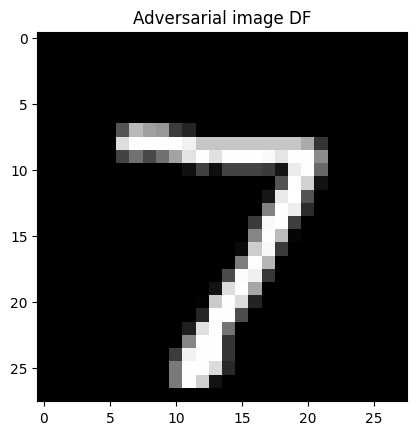

In [37]:
# Visualize the  image  after generating DeepFool attack
plt.imshow(np.transpose(x_test_adv_DF[0], (1, 2, 0)),cmap='gray')
plt.title("Adversarial image DF")
plt.show()

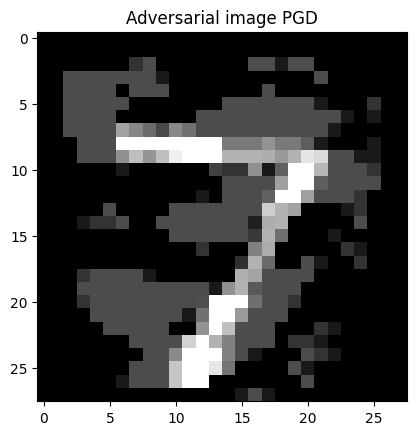

In [27]:
# Visualize the  image  after generating PGD attack
plt.imshow(np.transpose(x_test_adv_PGD[0], (1, 2, 0)),cmap='gray')
plt.title("Adversarial image PGD")
plt.show()

In [18]:
#  Evaluate the ART classifier on FGD adv examples
predictions = classifier.predict(x_test_adv_FGD)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on adversarial test examples FGD: {}%".format(accuracy * 100))


Accuracy on adversarial test examples FGD: 59.3%


In [36]:
#  Evaluate the ART classifier on DF adv examples
predictions = classifier.predict(x_test_adv_DF)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on adversarial test examples DF: {}%".format(accuracy * 100))

Accuracy on adversarial test examples DF: 62.260000000000005%


In [29]:
#  Evaluate the ART classifier on PGD adv examples
predictions = classifier.predict(x_test_adv_PGD)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on adversarial test examples PGD: {}%".format(accuracy * 100))


Accuracy on adversarial test examples PGD: 14.87%


# Explanation on Orignal and adv samples


[tensor([7, 2, 1, 0, 4])]


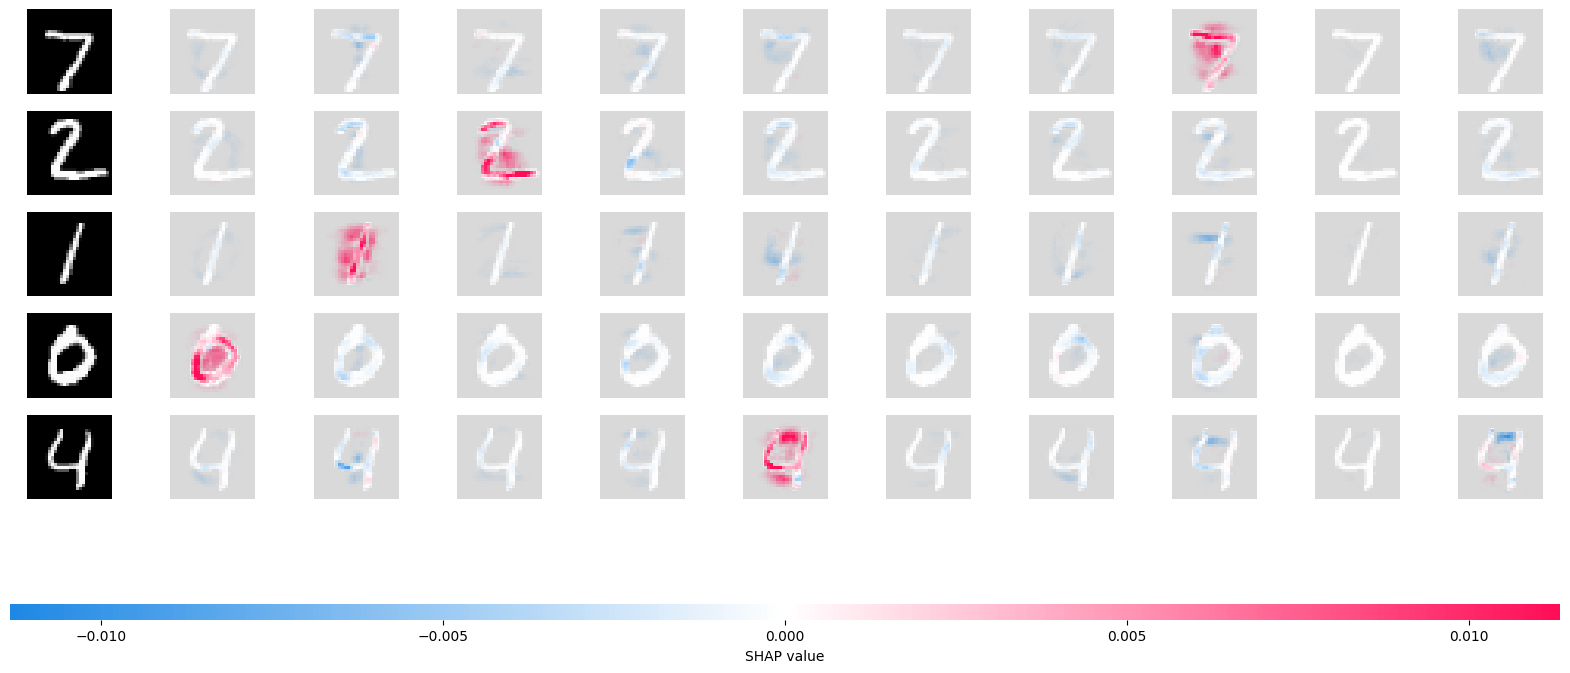

In [24]:
#use shap method to explain original image
x_testtensor = torch.from_numpy(x_test)
background = x_testtensor[:100]
test_images = x_testtensor[:5]
pred_list=[]
with torch.no_grad():
   outputs = model(test_images)
   _, predicted = torch.max(outputs.data, 1)
   pred_list.append(predicted)
print(pred_list)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

[tensor([7, 2, 6, 0, 9])]


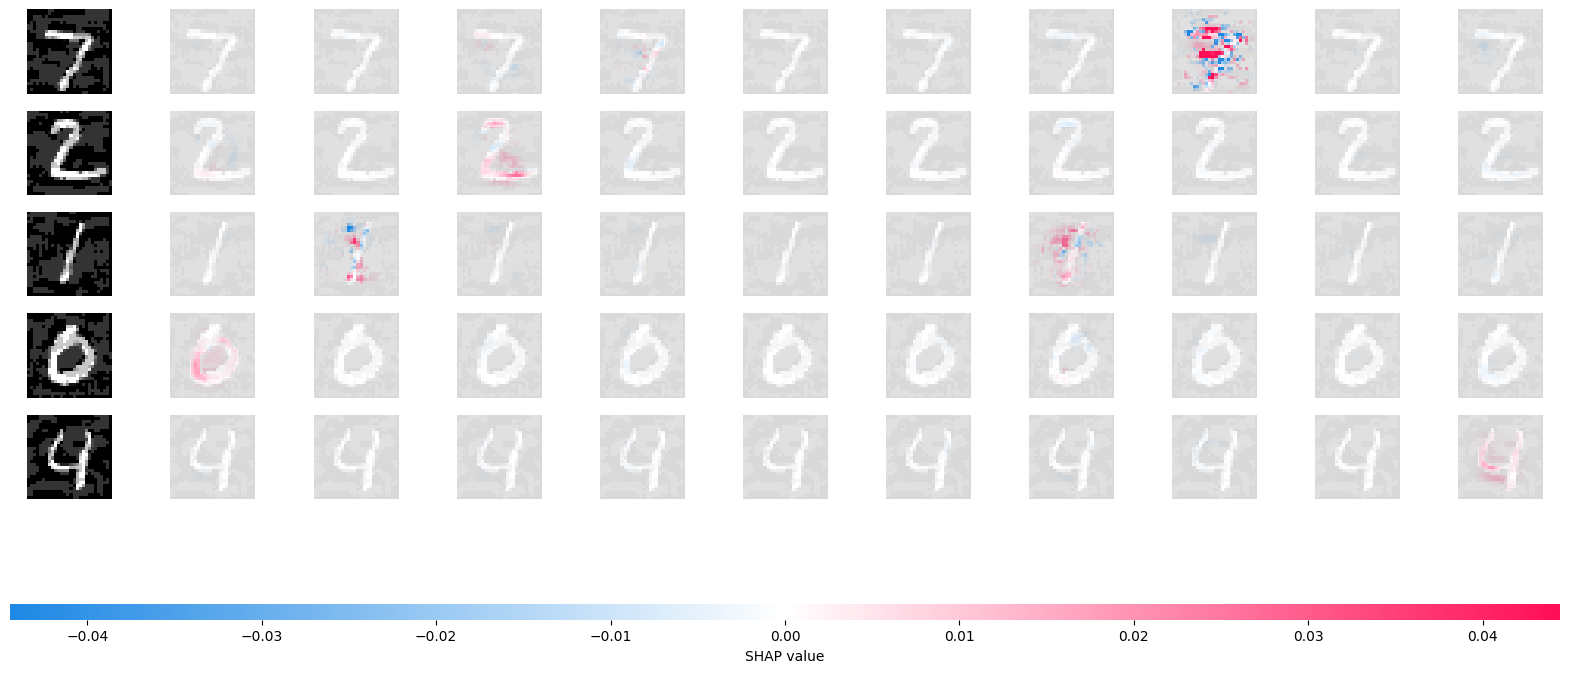

In [25]:
#use shap method to explain original image
x_testtensor = torch.from_numpy(x_test_adv_FGD)
background = x_testtensor[:100]
test_images = x_testtensor[:5]
pred_list=[]
with torch.no_grad():
   outputs = model(test_images)
   _, predicted = torch.max(outputs.data, 1)
   pred_list.append(predicted)
print(pred_list)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

[tensor([3, 8, 2, 7, 3])]


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


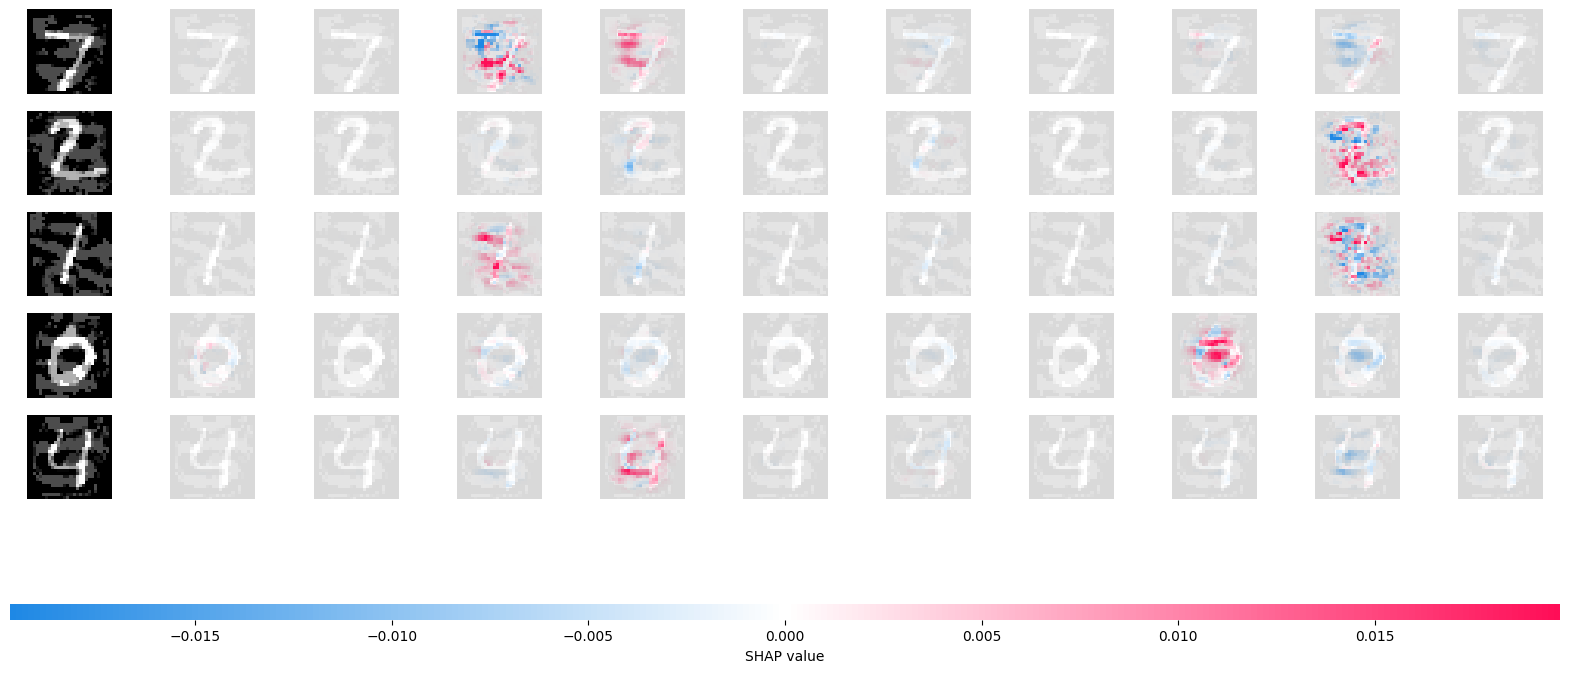

In [30]:
#use shap method to explain original image
x_testtensor = torch.from_numpy(x_test_adv_PGD)
background = x_testtensor[:100]
test_images = x_testtensor[:5]
pred_list=[]
with torch.no_grad():
   outputs = model(test_images)
   _, predicted = torch.max(outputs.data, 1)
   pred_list.append(predicted)
print(pred_list)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

[tensor([7, 2, 7, 0, 4])]


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


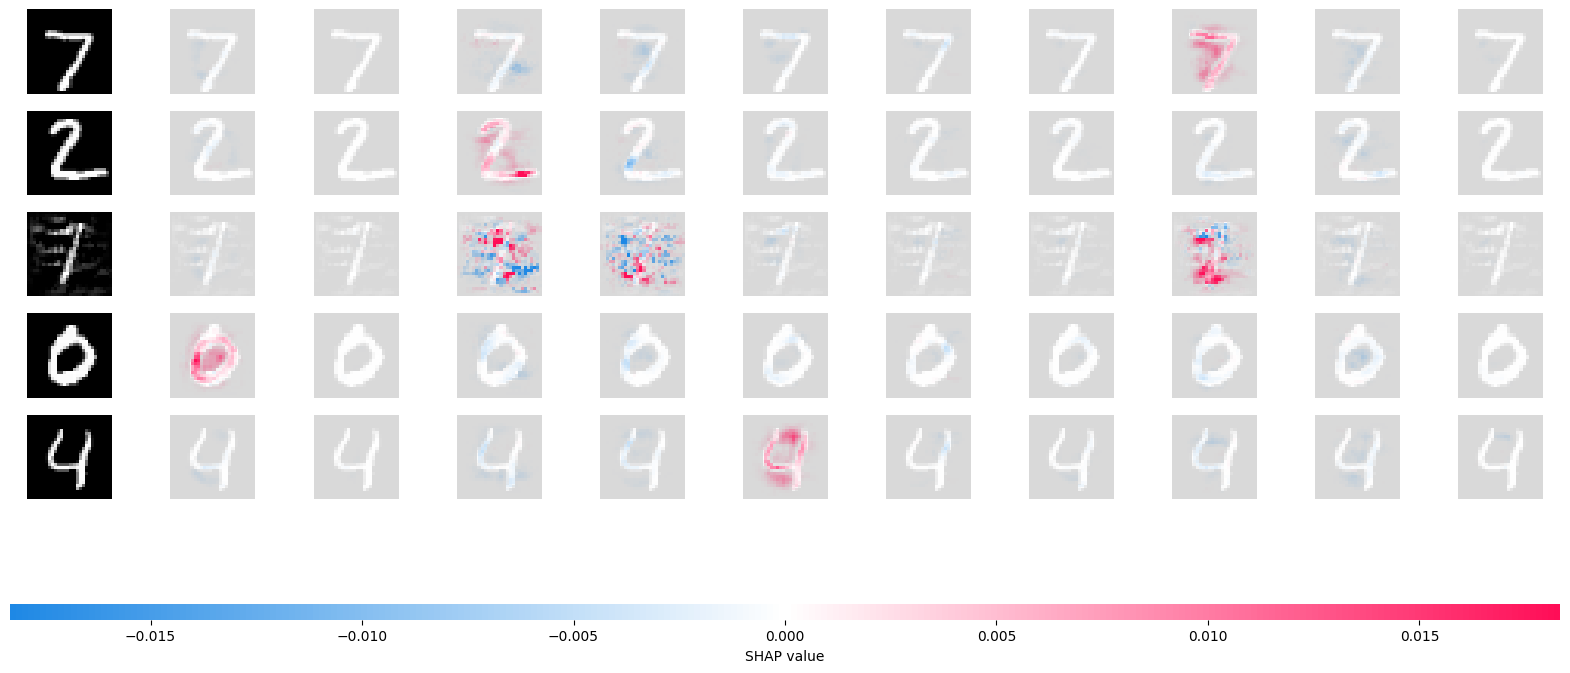

In [35]:
#use shap method to explain original image
x_testtensor = torch.from_numpy(x_test_adv_DF)
background = x_testtensor[:100]
test_images = x_testtensor[:5]
pred_list=[]
with torch.no_grad():
   outputs = model(test_images)
   _, predicted = torch.max(outputs.data, 1)
   pred_list.append(predicted)
print(pred_list)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

In [ ]:
################ choose one random image from the original test image to explain in captum ##############
# get the input_image and input_label from the above section
x_testtensor = torch.from_numpy(x_test)
test_images = x_testtensor[:5]
pred_list=[]
with torch.no_grad():
   outputs = model(test_images)
   _, predicted = torch.max(outputs.data, 1)
   pred_list.append(predicted)
idx=0 #the index in the test_images set
img=test_images[idx]
print("img", img.shape)
dummy_batch_img=test_images[idx].unsqueeze(0)
print("dummy_batch_img",dummy_batch_img.shape)
pred_label_idx=pred_list[0][idx]
print(pred_label_idx)

img torch.Size([1, 28, 28])
dummy_batch_img torch.Size([1, 1, 28, 28])
tensor(7)


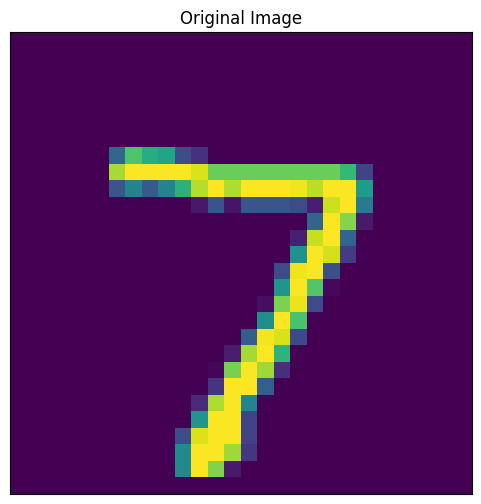

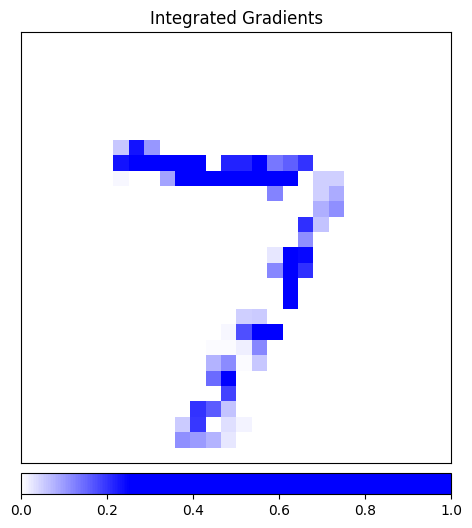

In [ ]:
#############  Use IG in captum to explain original image #############
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)
# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(dummy_batch_img, target=pred_label_idx, n_steps=200)
# Show the original image for comparison
_ = viz.visualize_image_attr(None,np.transpose(img.cpu().detach().numpy(), (1,2,0)),
                              method="original_image", title="Original Image"
                             )

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients'
                             )

Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.


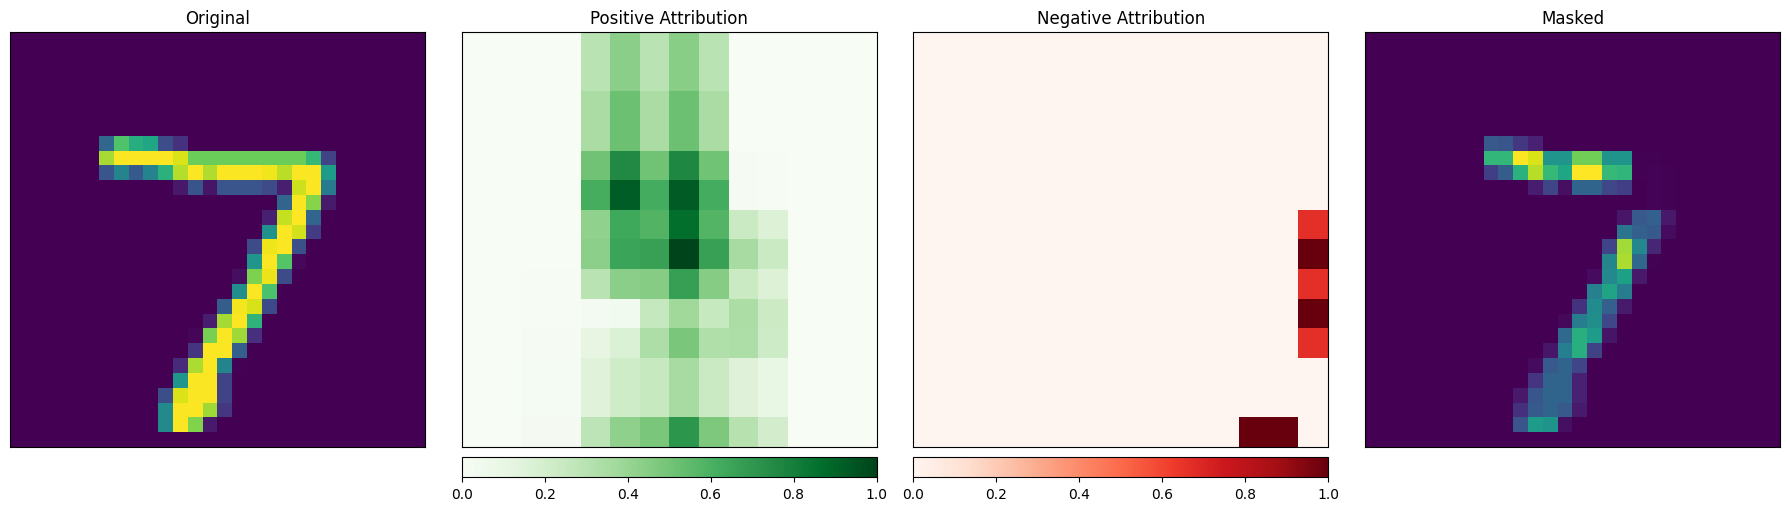

In [ ]:
############### use occlusion to explain original image ################
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(dummy_batch_img,
                                       target=pred_label_idx,
                                       strides=(1, 4, 4),
                                       sliding_window_shapes=(1,10, 10),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img.cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

In [ ]:
################ choose one random image to explain adv in captum ##############
# get the input_image and input_label from the above section

x_testtensor_DF = torch.from_numpy(x_test_adv_DF)
background = x_testtensor_DF[:100]
test_images = x_testtensor_DF[:5]
pred_list=[]
idx=0
with torch.no_grad():
   outputs = model(test_images)
   _, predicted = torch.max(outputs.data, 1)
   pred_list.append(predicted)
pred_label_idx=pred_list[0][idx]
print(pred_label_idx)
img=x_test_adv_DF[idx]
print("img", img.shape)
dummy_batch_img=test_images[idx].unsqueeze(0)
print("dummy_batch_img",dummy_batch_img.shape)


tensor(7)
img (1, 28, 28)
dummy_batch_img torch.Size([1, 1, 28, 28])


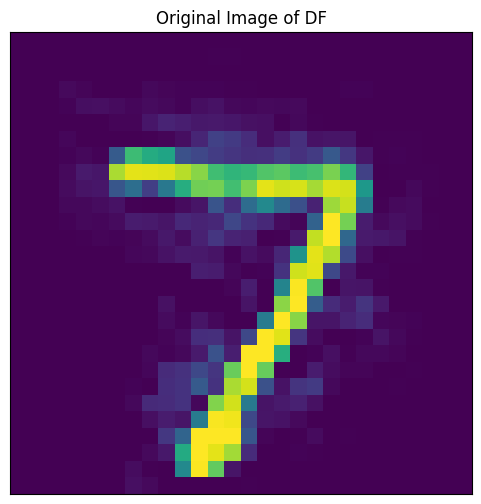

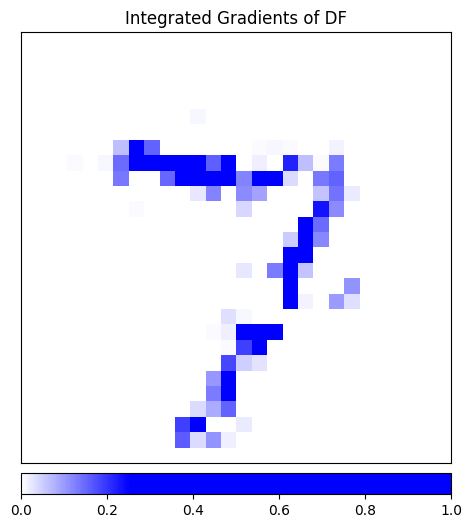

In [ ]:
#############  Use IG in captum to explain adv image #############
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)
# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(dummy_batch_img, target=pred_label_idx, n_steps=200)
# Show the original image for comparison
_ = viz.visualize_image_attr(None,np.transpose(img, (1,2,0)),
                              method="original_image", title="Original Image of DF"
                             )

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img, (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients of DF'
                             )

tensor(3)


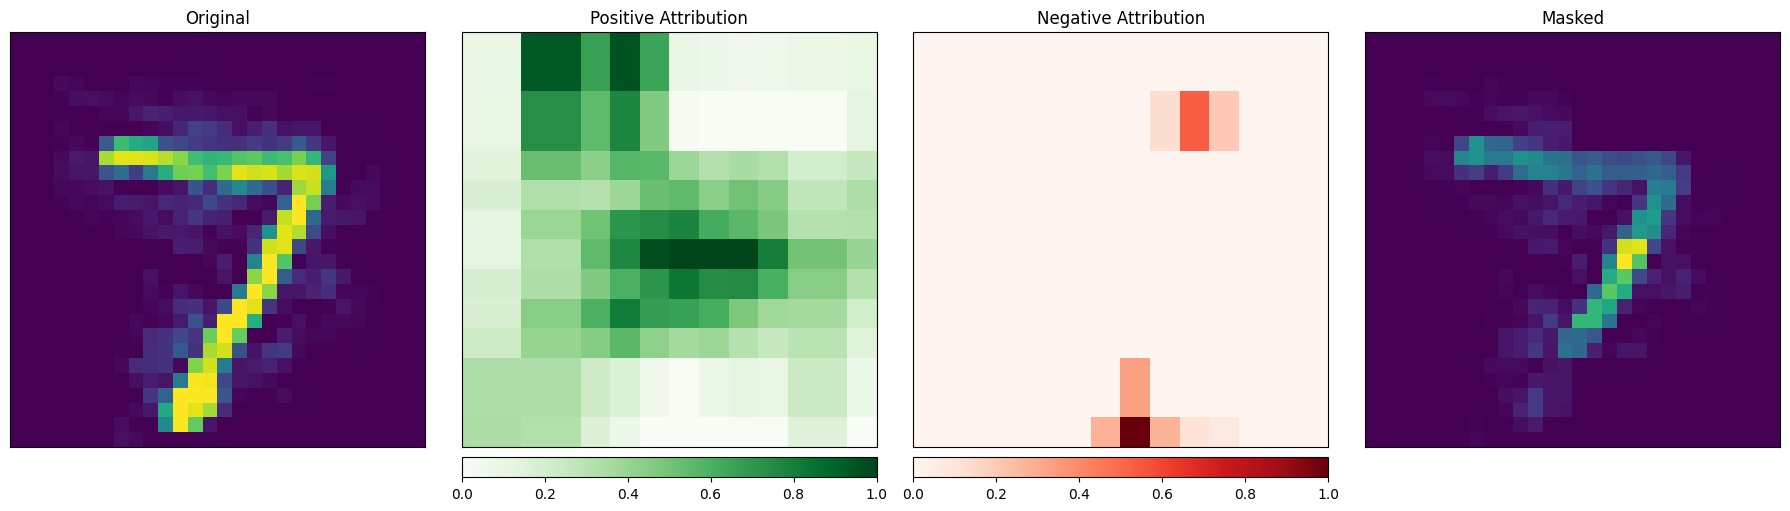

In [ ]:
############### use occlusion to explain adv image ################
occlusion = Occlusion(model)
print(pred_label_idx)
attributions_occ = occlusion.attribute(dummy_batch_img,
                                       target=pred_label_idx,
                                       strides=(1, 4, 4),
                                       sliding_window_shapes=(1,10, 10),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(img, (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

In [ ]:
################ choose one random image to explain adv in captum ##############
# get the input_image and input_label from the above section
x_testtensor_FGD= torch.from_numpy(x_test_adv_FGD)
test_images = x_testtensor_FGD[:5]
pred_list=[]
idx=0
with torch.no_grad():
   outputs = model(test_images)
   _, predicted = torch.max(outputs.data, 1)
   pred_list.append(predicted)
pred_label_idx=pred_list[0][idx]
print(pred_label_idx)
img=x_test_adv_FGD[idx]
print("img", img.shape)
dummy_batch_img=test_images[idx].unsqueeze(0)
print("dummy_batch_img",dummy_batch_img.shape)


tensor(3)
img (1, 28, 28)
dummy_batch_img torch.Size([1, 1, 28, 28])


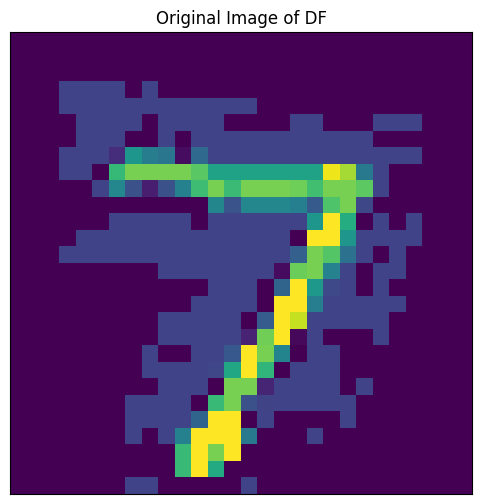

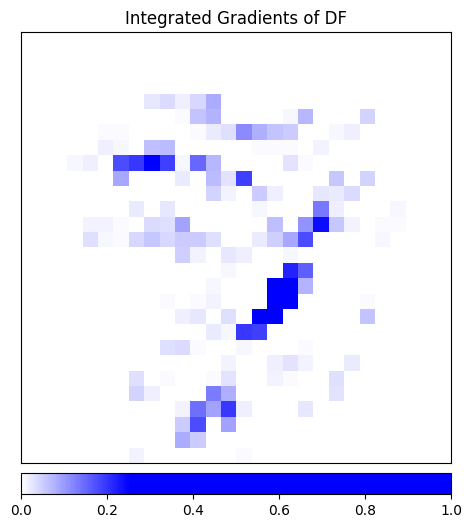

In [ ]:
#############  Use IG in captum to explain adv image #############
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)
# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(dummy_batch_img, target=pred_label_idx, n_steps=200)
# Show the original image for comparison
_ = viz.visualize_image_attr(None,np.transpose(img, (1,2,0)),
                              method="original_image", title="Original Image of DF"
                             )

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img, (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients of DF'
                             )

tensor(3)


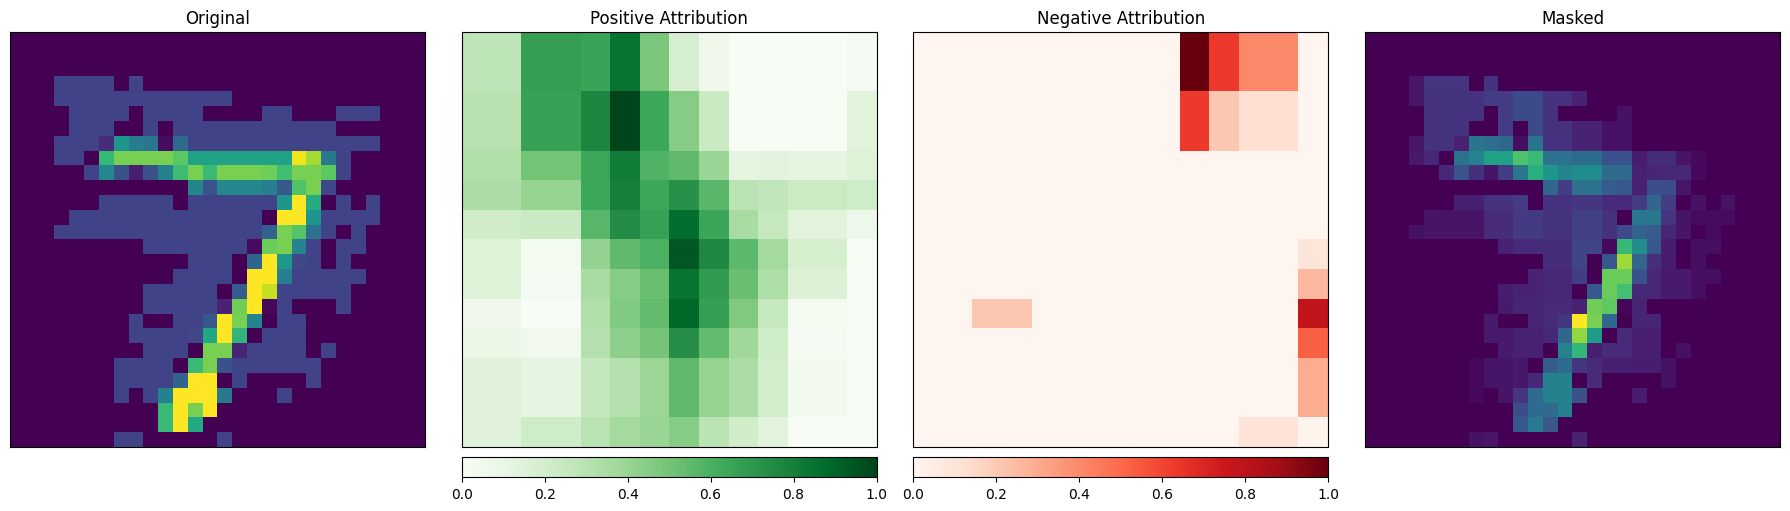

In [ ]:
############### use occlusion to explain adv image ################
occlusion = Occlusion(model)
print(pred_label_idx)
attributions_occ = occlusion.attribute(dummy_batch_img,
                                       target=pred_label_idx,
                                       strides=(1, 4, 4),
                                       sliding_window_shapes=(1,10, 10),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(img, (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

In [38]:
############### choose one random image to explain adv in captum ##############
# get the input_image and input_label from the above section
x_testtensor_PGD= torch.from_numpy(x_test_adv_PGD)
test_images = x_testtensor_PGD[:5]
pred_list=[]
idx=0
with torch.no_grad():
   outputs = model(test_images)
   _, predicted = torch.max(outputs.data, 1)
   pred_list.append(predicted)
pred_label_idx=pred_list[0][idx]
print(pred_label_idx)
img=x_test_adv_FGD[idx]
print("img", img.shape)
dummy_batch_img=test_images[idx].unsqueeze(0)
print("dummy_batch_img",dummy_batch_img.shape)


tensor(7)
img (1, 28, 28)
dummy_batch_img torch.Size([1, 1, 28, 28])


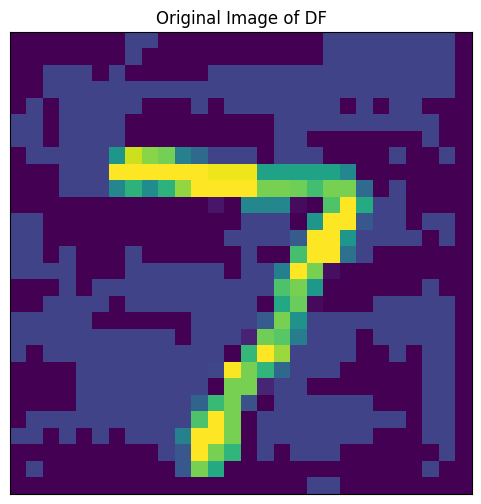

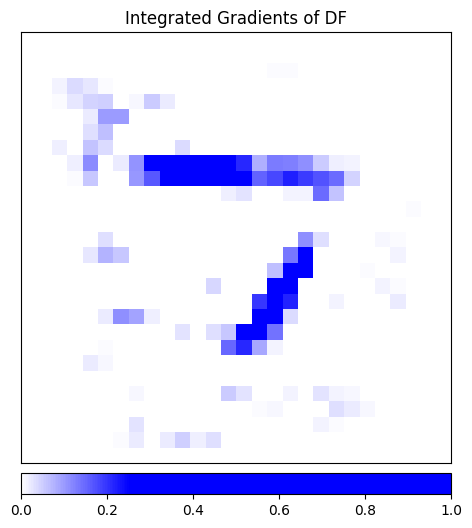

In [39]:
#############  Use IG in captum to explain adv image #############
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)
# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(dummy_batch_img, target=pred_label_idx, n_steps=200)
# Show the original image for comparison
_ = viz.visualize_image_attr(None,np.transpose(img, (1,2,0)),
                              method="original_image", title="Original Image of DF"
                             )

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img, (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients of DF'
                             )

tensor(7)


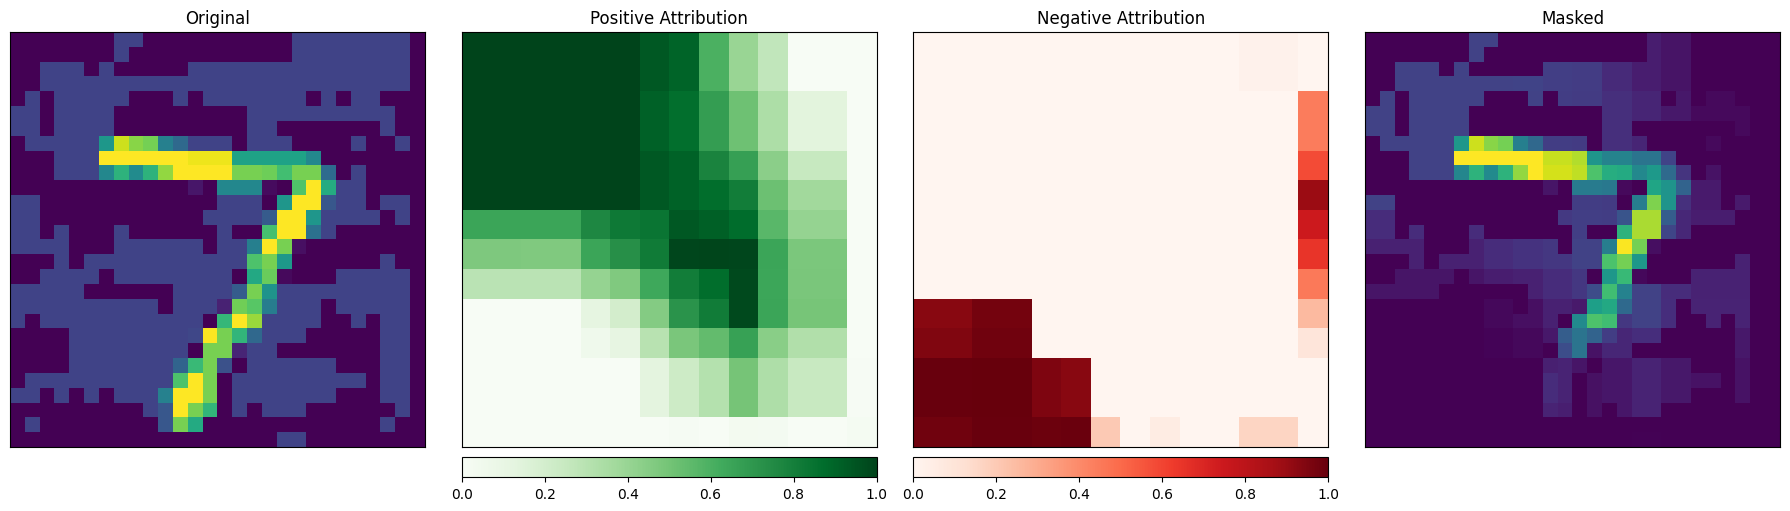

In [40]:
############### use occlusion to explain adv image ################
occlusion = Occlusion(model)
print(pred_label_idx)
attributions_occ = occlusion.attribute(dummy_batch_img,
                                       target=pred_label_idx,
                                       strides=(1, 4, 4),
                                       sliding_window_shapes=(1,10, 10),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(img, (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )